In [14]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
import xml.etree.ElementTree as ET
from typing import Any, Callable, Dict, Optional, Tuple, List
import collections
from torch.utils.data import Dataset, DataLoader


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [4]:
vgg16 = models.vgg16(pretrained=True).features[:-1].to(device)

print(vgg16)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [5]:
from torchsummary import summary
summary(vgg16, input_size=(3,244,244), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

torch.Size([64, 3, 3, 3])


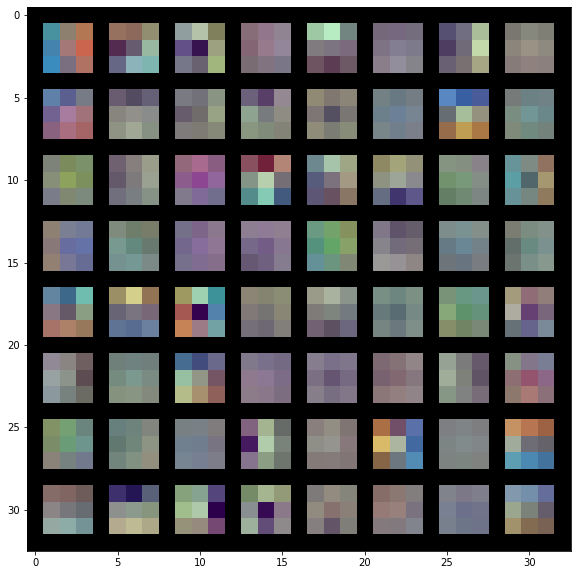

In [6]:
# visualize the filters of the first CNN layer
# display sample images
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels: ' + str(y))

for w in vgg16.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
show(x_grid)


In [8]:
path2data = '../../../../../../data/test/Annotations'

In [9]:
classes = ["wasp nest"]

In [ ]:
import xml.etree.ElementTree as Et

def xml_parser(xml_path):
    xml_path = xml_path
    xml = open(xml_path, "r")
    tree = Et.parse(xml)
    root = tree.getroot()
    size = root.find("size")
    file_name = root.find("filename").text
    object_name = []
    bbox = []
    objects = root.findall("object")
    for _object in objects:
      name = _object.find("name").text
      object_name.append(name)
      bndbox = _object.find("bndbox")
      one_bbox = []
      xmin = bndbox.find("xmin").text
      one_bbox.append(int(float(xmin)))
      ymin = bndbox.find("ymin").text
      one_bbox.append(int(float(ymin)))
      xmax = bndbox.find("xmax").text
      one_bbox.append(int(float(xmax)))
      ymax = bndbox.find("ymax").text
      one_bbox.append(int(float(ymax)))
      bbox.append(one_bbox)
    return file_name, object_name, bbox


In [ ]:
def makeBox(voc_im,bbox,objects):
    image = voc_im.copy()
    for i in range(len(objects)):
        cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
        cv2.putText(image, objects[i], (int(bbox[i][0]), int(bbox[i][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2) # 크기, 색, 굵기
    return image

In [ ]:
xml_list = os.listdir("../../../../../../data/test/Annotations")
xml_list.sort()

label_set = set()

for i in range(len(xml_list)):
  xml_path = "../../../../../../data/test/Annotations/"+str(xml_list[i])
  file_name, object_name, bbox = xml_parser(xml_path)
  for name in object_name:
    label_set.add(name)

label_set = sorted(list(label_set))

label_dic = {}
for i, key in enumerate(label_set):
  label_dic[key] = (i+1)
print(label_dic)


In [ ]:
import imgaug as ia
from imgaug import augmenters as iaa
from torch.utils.data import Dataset, DataLoader

class Pascal_Voc(Dataset):
    
  def __init__(self,xml_list,len_data):

    self.xml_list = xml_list
    self.len_data = len_data
    self.to_tensor = transforms.ToTensor()
    self.flip = iaa.Fliplr(0.5)
    self.resize = iaa.Resize({"shorter-side": 600, "longer-side": "keep-aspect-ratio"})

  def __len__(self):
    return self.len_data

  def __getitem__(self, idx):

    xml_path = "../../../../../../data/test/Annotations/"+str(xml_list[idx])

    file_name, object_name, bbox = xml_parser(xml_path)
    image_path = "../../../../../../data/test/JPEGImages/"+str(file_name)
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)

    image, bbox = self.flip(image = image, bounding_boxes = np.array([bbox]))
    image, bbox = self.resize(image = image,bounding_boxes = bbox)
    bbox = bbox.squeeze(0).tolist()
    image = self.to_tensor(image)

    targets = []
    d = {}
    d['boxes'] = torch.tensor(bbox,device=device)
    d['labels'] = torch.tensor([label_dic[x] for x in object_name],dtype=torch.int64,device = device)
    targets.append(d)

    return image, targets


In [15]:
# PyTorch에서 제공하는 VOC dataset을 상속받아, custom dataset을 생성합니다.
class myVOCDetection(Dataset):
    def __getitem__(self, index):
        img = np.array(Image.open(self.images[index]).convert('RGB'))
        target = self.parse_voc_xml(
            ET.parse(self.annotations[index]).getroot())  # xml파일 분석하여 dict으로 받아오기

        targets = []  # 바운딩 박스 좌표
        labels = []  # 바운딩 박스 클래스

        # 바운딩 박스 정보 받아오기
        for t in target['annotation']['object']:
            label = np.zeros(5)
            label[:] = t['bndbox']['xmin'], t['bndbox']['ymin'], t['bndbox']['xmax'], t['bndbox']['ymax'], classes.index(
                t['name'])

            targets.append(list(label[:4]))  # 바운딩 박스 좌표
            labels.append(label[4])         # 바운딩 박스 클래스

        if self.transforms:
            augmentations = self.transforms(image=img, bboxes=targets)
            img = augmentations['image']
            targets = augmentations['bboxes']

        return img, targets, labels

    # xml 파일을 dictionary로 반환
    def parse_voc_xml(self, node: ET.Element) -> Dict[str, Any]:
        voc_dict: Dict[str, Any] = {}
        children = list(node)
        if children:
            def_dic: Dict[str, Any] = collections.defaultdict(list)
            for dc in map(self.parse_voc_xml, children):
                for ind, v in dc.items():
                    def_dic[ind].append(v)
            if node.tag == "annotation":
                def_dic["object"] = [def_dic["object"]]
            voc_dict = {node.tag: {ind: v[0] if len(
                v) == 1 else v for ind, v in def_dic.items()}}
        if node.text:
            text = node.text.strip()
            if not children:
                voc_dict[node.tag] = text
        return voc_dict


In [ ]:
train_ds = torchvision.datasets.ImageFolder(root="baby_data/train", transform=transforms.ToTensor())


In [ ]:
# 샘플 이미지 확인
img, target, label = train_ds[2]
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')  # 바운딩 박스 색상

# 시각화 함수


def show(img, targets, labels, classes=classes):
    img = to_pil_image(img)
    draw = ImageDraw.Draw(img)
    targets = np.array(targets)
    W, H = img.size

    for tg, label in zip(targets, labels):
        id_ = int(label)  # class
        bbox = tg[:4]    # [x1, y1, x2, y2]

        color = [int(c) for c in colors[id_]]
        name = classes[id_]

        draw.rectangle(((bbox[0], bbox[1]), (bbox[2], bbox[3])),
                       outline=tuple(color), width=3)
        draw.text((bbox[0], bbox[1]), name, fill=(255, 255, 255, 0))
    plt.imshow(np.array(img))


plt.figure(figsize=(10, 10))
show(img, target, label)
